In [1]:
import sys
import time
import csv
import math
import numpy as np
import pyspark
from pyspark import SparkContext, SparkConf
import json
from operator import add
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from node2vec import Node2Vec as n2v
import networkx as nx
from hashlib import md5
import pickle
import os
import pandas as pd
from xgboost import XGBRegressor

pd.set_option("display.max_columns", 100)
pd.set_option('display.width', 100)
pd.set_option("display.precision", 2)

folder_path = "../data/"
test_filepath = "../yelp_true.csv"
output_filepath = ""

from utils import create_category_md5_mapping, integrate_mapping_user_bus_cat_data, dataframe_to_rdd_dict, analyze_top_business_categories, analyze_top_categories

import json
import numpy as np
from pyspark import SparkContext, SparkConf
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

def initialize_spark_context(APP_NAME="Train: XGBModel"):
    # Spark配置项列表
    SPARK_CONF = [
        ("spark.dynamicAllocation.enabled", "true"),  # 启用动态资源分配
        ("spark.dynamicAllocation.maxExecutors", "10"),  # 最大执行器数量
        ("spark.executor.memory", "3g"),  # 每个执行器的内存
        ("spark.executor.cores", "2"),  # 每个执行器的CPU核心数
        ("spark.executor.memoryOverhead", "3000"),  # 执行器内存开销
        ("spark.driver.memory", "4g"),  # 驱动程序的内存
        ("spark.driver.maxResultSize", "2g"),  # 驱动程序的最大结果大小
        ("spark.python.worker.memory", "2g"),  # Python工作进程的内存
        ("spark.sql.shuffle.partitions", "20"),  # Shuffle操作的分区数
        ("spark.sql.sources.partitionOverWriteMode", "dynamic"),  # 分区覆写模式
        ("spark.network.timeout", "600s"),  # 网络超时设置
        ("spark.executor.heartbeatInterval", "120s"),  # 执行器心跳间隔
    ]

    # 创建Spark配置
    spark_conf = pyspark.SparkConf()
    spark_conf.setAppName(APP_NAME)
    spark_conf.setAll(SPARK_CONF)

    # 创建SparkContext
    sc = pyspark.SparkContext(conf=spark_conf)
    sc.setLogLevel("ERROR")  # 设置日志级别

    return sc

sc = initialize_spark_context()

24/04/30 23:19:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Begin

In [2]:
import better_features
from better_features import FeatureProcessor, read_json_data
from datetime import datetime #add


def rdd_to_pandas(rdd):
    return pd.DataFrame(rdd.collect(), columns=rdd.first().keys())

### RE-DO HERE IF NECESSARY (changed features)

In [6]:
import better_features
from better_features import FeatureProcessor, read_json_data, transform_user_data, transform_business_data,extract_review_data
from datetime import datetime #add

def rdd_to_pandas(rdd):
    return pd.DataFrame(rdd.collect(), columns=rdd.first().keys())

user_rdd = sc.textFile(folder_path + '/user.json').map(transform_user_data)
user_df = rdd_to_pandas(user_rdd)

business_rdd = sc.textFile(folder_path + '/business.json').map(transform_business_data)
business_df = rdd_to_pandas(business_rdd)
# business_dict = read_json_data(folder_path + '/business.json', extract_business_data, sc).collectAsMap()

review_data = read_json_data(folder_path + '/review_train.json', extract_review_data, sc).collect()

In [4]:
review_data = read_json_data(folder_path + '/review_train.json', extract_review_data, sc)
review_df = rdd_to_pandas(review_data)

In [10]:
user_df.to_csv('cache/user_df.csv', index=False)
business_df.to_csv('cache/business_df.csv', index=False)
review_df.to_csv('cache/review_df.csv', index=False)

In [ ]:
# not consider now

## Now start to combine features

In [3]:
# def rdd_to_pandas(rdd):
#     return pd.DataFrame(rdd.collect(), columns=rdd.first().keys())

# user_rdd = sc.textFile(folder_path + '/user.json').map(transform_user_data)
# user_df = rdd_to_pandas(user_rdd)

# business_rdd = sc.textFile(folder_path + '/business.json').map(transform_business_data)
# business_df = rdd_to_pandas(business_rdd)
# # business_dict = read_json_data(folder_path + '/business.json', extract_business_data, sc).collectAsMap()
# review_data = read_json_data(folder_path + '/review_train.json', extract_review_data, sc)
# review_df = rdd_to_pandas(review_data)

# # user_df.to_csv('cache/user_df.csv', index=False)
# # business_df.to_csv('cache/business_df.csv', index=False)
# # review_df.to_csv('cache/review_df.csv', index=False)

In [3]:
# start_time = time.time()

# user_df = pd.read_csv('cache/user_df.csv') # parsed from users.json
# business_df = pd.read_csv('cache/business_df.csv') # parsed from business.json
# review_df = pd.read_csv('cache/review_df.csv') # parsed from business.json
# print("Duration: ", time.time() - start_time)

Duration:  7.745426654815674


In [4]:
# # 计算每个用户的总年度反馈计数
# total_ufc_per_year = review_df.groupby('user_id')['ufc_count_per_year'].sum().reset_index()
# total_ufc_per_year.rename(columns={'ufc_count_per_year': 'total_ufc_count_per_year'}, inplace=True)
# user_df = user_df.merge(total_ufc_per_year, on='user_id', how='left')
# user_df['total_ufc_count_per_year'] = user_df['total_ufc_count_per_year'].fillna(0) # solve cold start

# # 计算每个用户的平均评论反馈计数
# avg_ufc_per_review = review_df.groupby('user_id')['ufc_count'].mean().reset_index()
# avg_ufc_per_review.rename(columns={'ufc_count': 'avg_ufc_count_per_review'}, inplace=True)

# # 合并到用户DataFrame并处理冷启动问题
# user_df = user_df.merge(avg_ufc_per_review, on='user_id', how='left')
# user_df['avg_ufc_count_per_review'] = user_df['avg_ufc_count_per_review'].fillna(0) # solve cold start

In [5]:
# import pandas as pd

# # 计算每个商家的总年度反馈计数
# total_ufc_per_year_biz = review_df.groupby('business_id')['ufc_count_per_year'].sum().reset_index()
# total_ufc_per_year_biz.rename(columns={'ufc_count_per_year': 'total_ufc_count_per_year'}, inplace=True)
# business_df = business_df.merge(total_ufc_per_year_biz, on='business_id', how='left')
# business_df['total_ufc_count_per_year'] = business_df['total_ufc_count_per_year'].fillna(0)  # Handling cold start for businesses

# # 计算每个商家的平均评论反馈计数
# avg_ufc_per_review_biz = review_df.groupby('business_id')['ufc_count'].mean().reset_index()
# avg_ufc_per_review_biz.rename(columns={'ufc_count': 'avg_ufc_count_per_review'}, inplace=True)
# business_df = business_df.merge(avg_ufc_per_review_biz, on='business_id', how='left')
# business_df['avg_ufc_count_per_review'] = business_df['avg_ufc_count_per_review'].fillna(0)  # Handling cold start for businesses

In [6]:
# print("Duration: ", time.time() - start_time)

Duration:  8.227460145950317


# START HERE Load Train Data and evaluate
StandardScaler(), z-score?

In [3]:
import better_features
from better_features import FeatureProcessor, read_json_data, transform_user_data, transform_business_data, extract_review_data
from datetime import datetime #add

def rdd_to_pandas(rdd):
    return pd.DataFrame(rdd.collect(), columns=rdd.first().keys())

start_time = time.time()

user_df = pd.read_csv('cache/user_df.csv') # parsed from users.json
business_df = pd.read_csv('cache/business_df.csv') # parsed from business.json
review_df = pd.read_csv('cache/review_df.csv') # parsed from business.json

print("Duration: ", time.time() - start_time)

Duration:  4.18523383140564


In [4]:
from KMeans_user_cluster import KMeans_process_user_clusters

def process_features(data_file_path, feature_processor, user_clusters):
    df = feature_processor.process_all_features(sc, pd.read_csv(data_file_path), data_file_path)
    df = df.merge(user_clusters, on='user_id', how='left')
    return df

In [5]:
############################

In [6]:
# user_df, business_df = process_and_combine_features(user_df, business_df, review_df)

from better_features import FeatureProcessor

data_folder_path = '../data/'
train_data_file = '../data/yelp_train.csv'
test_data_file = '../data/yelp_true.csv'

feature_processor = FeatureProcessor(sc, data_folder_path, user_df, business_df, review_df)
user_clusters = KMeans_process_user_clusters(feature_processor.map_reviews_with_categories(), business_df)

print("[2/4] Processor init. and Cluster pre-processing completed!")
print(f"Elapsed time: {time.time() - start_time:.2f} seconds\n")

##############################################################################################################################
print("------[3/4] Starting Collecting User-Biz Interaction-Level features for Train and Test Data-------\n")

'''# Train data feature processing'''
train_data_file = f"{data_folder_path}/yelp_train.csv"
print("train_file: ", train_data_file)
train_df = process_features(train_data_file, feature_processor, user_clusters)

print("==== Training data User-Biz Interaction-Level features processed.")
################################################################################################
'''# Test data feature processing'''
print("test_file: ", test_data_file)
val_df = process_features(test_data_file, feature_processor, user_clusters)

print("==== Testing data User-Biz Interaction-Level features processed.")

print("[3/4] All Data User-Biz Interaction-Level features processed.")
print(f"Elapsed time: {time.time() - start_time:.2f} seconds\n")

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[2/4] Processor init. and Cluster pre-processing completed!
Elapsed time: 48.48 seconds

------[3/4] Starting Collecting User-Biz Interaction-Level features for Train and Test Data-------

train_file:  ../data//yelp_train.csv


==== Training data User-Biz Interaction-Level features processed.
test_file:  ../data/yelp_true.csv


==== Testing data User-Biz Interaction-Level features processed.
[3/4] All Data User-Biz Interaction-Level features processed.
Elapsed time: 59.88 seconds



In [7]:
train_df[(train_df['affinity_score'] > 2) & (train_df['affinity_score'] <= 5.0)]

,user_id,business_id,stars,score,average_stars,user_review_count,fans,useful,funny,cool,num_interactions,yelping_since,friends_count,elite_years,compliments,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_writer,compliment_photos,total_ufc_count_per_year,avg_ufc_count_per_review,bus_stars,bus_review_count,is_open,city_encoded,affinity_score,Cluster
20,Ez8ifxrtOUT5TM4817scOQ,glTBzDHv9wNhEsZa4bQrOA,2.0,0.51,3.68,472,9,92,37,38,167,14,173,2,60,9,0,0,1,0,8,8,12,10,0,4.90,1.82,3.0,176,0,416,4.71,0
32,en3OMUKWjeON-1-6wo8VrQ,1BrIPwRhJHOp6yBwjoRtgg,5.0,0.51,4.29,68,2,3,1,2,6,13,169,0,13,1,2,0,0,0,4,2,1,1,1,5.55,1.42,4.5,774,1,416,4.74,0
36,HVJgTH5qu0goywOHNpOjPA,M8a5DRdXl8KMu4bMFLPgQg,5.0,0.50,4.56,129,139,254,35,15,304,17,966,7,1132,206,22,11,23,0,88,149,190,178,75,90.29,24.22,3.5,96,1,416,3.84,0
168,UYp9lazOwsIIaLwVrDrAQw,LIvXzdMJrIb6IY5Y3tqicA,4.0,0.50,3.95,135,10,111,10,36,157,12,49,4,92,8,3,0,0,0,9,15,20,17,0,13.28,3.43,3.5,296,0,155,3.66,0
235,wZPizeBxMAyOSl0M0zuCjg,N0apJkxIem2E8irTBRKnHw,2.0,0.51,3.62,4175,378,1873,705,2335,4913,16,3615,10,2628,283,35,36,27,16,216,598,549,218,101,75.72,12.79,4.0,1556,1,416,4.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455740,RD-f1At-TwojTfXFuyN5ag,aUrOyWFKxKeVXiFzwbTXSA,2.0,0.49,3.66,158,1,11,6,8,25,16,6,0,17,1,0,0,0,0,8,4,1,2,0,7.45,2.89,4.0,264,1,463,3.44,0
455747,v6CKIUCUQYm4LZPFxgvMww,F0lI9okn4pzmN_iq5UqF7w,2.0,0.50,3.68,95,0,8,0,0,8,13,1,0,8,0,1,0,0,0,0,2,2,1,0,3.52,1.78,3.5,305,1,416,3.47,0
455768,3yMtpQ_wV4ZGg6E69uE1PQ,ZhACHVw9k438Z3i-Gw9BHA,5.0,0.49,3.42,129,13,77,36,58,171,9,36,3,23,2,3,0,0,0,2,5,2,6,1,26.31,3.42,4.5,87,1,984,3.35,0
455803,maWvpPYNCwEGhGmp8moC_A,vdOf_NWsct8jr4qYKoE_iw,5.0,0.48,3.50,46,2,5,0,0,5,13,18,0,8,0,2,0,0,0,1,2,1,1,0,6.72,2.50,4.5,355,0,416,2.69,0


Number of rows with affinity_score approximately equal to 0: 807


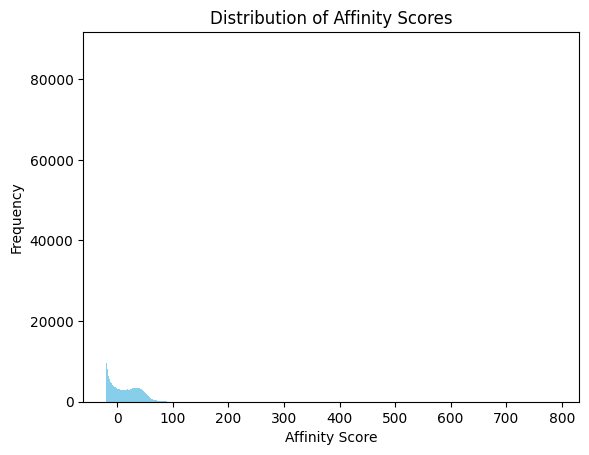

count    455854.00
mean         19.67
std          28.12
min         -21.06
25%          -7.96
50%          21.18
75%          50.00
max         790.84
Name: affinity_score, dtype: float64


In [11]:
specific_value = 0  # 您要查询的特定affinity_score值
tolerance = 0.1  # 容忍范围，根据实际情况调整
count_specific_value = final_df[(final_df['affinity_score'] >= specific_value - tolerance) & 
                                (final_df['affinity_score'] <= specific_value + tolerance)].shape[0]
print(f"Number of rows with affinity_score approximately equal to {specific_value}: {count_specific_value}")

# 获取整个数据集中的affinity_score分布情况
import matplotlib.pyplot as plt

plt.hist(final_df['affinity_score'], bins=1000, color='skyblue')  # bins参数根据需要调整
plt.title('Distribution of Affinity Scores')
plt.xlabel('Affinity Score')
plt.ylabel('Frequency')
plt.show()

# 也可以用describe方法来获取统计信息
print(final_df['affinity_score'].describe()) # 极端的正偏态分布

In [9]:
# # sanity check
# original_count = len(train_df)  # 获取原始DataFrame的行数
# final_df_count = len(final_df)  # 计算处理后的RDD的行数

# print(f"Original count: {original_count}, Final DF count: {final_df_count}")

In [10]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# features = train_df.drop(['stars', 'user_id', 'business_id'], axis=1)  # 或其他目标变量列
# labels = train_df['stars'] 

# # 分割数据集
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# # 标准化特征（如果需要）
# # scaler = StandardScaler()
# # X_train = scaler.fit_transform(X_train)
# # X_test = scaler.transform(X_test)

In [124]:
# test_data_file = '../data/yelp_true.csv' # '../yelp_true.csv'

# df_val = pd.read_csv(test_data_file)
# processed_val_df = feature_processor.process_all_features(sc, df_val, test_data_file)
# processed_val_df = rdd_to_pandas(val_rdd)

y_train = train_df['stars']
X_train = train_df.drop(['stars', 'user_id', 'business_id'], axis=1)
# X_train = train_df.drop(['stars', 'user_id', 'business_id', 'city_encoded'], axis=1)

y_val = val_df['stars']
X_val = val_df.drop(['stars', 'user_id', 'business_id'], axis=1)
# X_val = val_df.drop(['stars', 'user_id', 'business_id', 'city_encoded'], axis=1)

In [119]:
X_train

,average_stars,user_review_count,fans,useful,funny,cool,num_interactions,yelping_since,friends_count,elite_years,compliments,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_writer,compliment_photos,total_ufc_count_per_year,avg_ufc_count_per_review,bus_stars,bus_review_count,is_open,affinity_score,Cluster
0,4.11,353,69,2005,1826,1872,5703,18,787,8,1183,213,15,6,4,0,65,192,269,115,35,187.80,12.39,4.0,876,1,42.57,0
1,3.92,433,12,22,19,33,74,14,109,4,79,7,4,2,0,0,7,18,15,8,3,2.16,1.24,3.0,369,1,5.48,0
2,3.69,154,9,2660,644,1003,4307,12,55,0,160,12,6,0,0,0,15,39,37,14,0,36.15,7.22,3.5,45,1,50.00,0
3,4.11,668,407,1214,180,826,2220,12,2598,6,1579,143,18,8,8,6,154,530,233,91,155,387.87,14.76,4.5,55,1,10.43,0
4,3.60,304,11,14,9,8,31,9,98,3,71,5,2,0,0,0,7,18,13,5,8,35.90,2.46,4.0,64,1,0.22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455849,3.47,951,81,16440,7770,15239,39449,15,174,8,751,55,10,8,3,4,73,175,174,66,9,15.57,4.46,4.0,1830,1,6.86,0
455850,3.63,63,5,8,3,0,11,12,99,0,13,0,0,1,0,0,1,1,2,5,1,5.97,3.16,1.0,32,1,50.00,0
455851,3.71,902,127,462,152,345,959,17,1221,10,2319,420,35,57,17,21,114,312,486,347,24,46.10,11.32,3.0,591,1,50.00,0
455852,3.33,52,1,27,10,23,60,14,151,0,7,0,1,0,0,0,1,3,1,0,0,3.97,1.56,4.0,453,1,-20.85,0


In [55]:
# # for testing
# #
# #
# y_train = val_df['stars']
# X_train = val_df.drop(['stars', 'user_id', 'business_id'], axis=1)

# y_val = train_df['stars']
# X_val = train_df.drop(['stars', 'user_id', 'business_id'], axis=1)

In [13]:
# X_train, X_val

## ONE-SHOT WITHOUT FINE-TUNING

In [15]:
import xgboost as xgb

# 初始化XGBRegressor
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.6072881476244077,
    'gamma': 0.3628798465362447,
    'learning_rate': 0.029227134470457283,
    'max_depth': 8,
    'n_estimators': 480,
    'subsample': 0.8869519293950694
}
model = XGBRegressor(**params)
# model = xgb.XGBRegressor(objective ='reg:squarederror', max_depth=7, learning_rate=0.05, n_estimators=300, max_leaves=120)

# 训练模型
model.fit(X_train, y_train)

# 预测测试集
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

In [ ]:
# MANNNNNNNNNNNNNNNNNNN

# FINE TUNING

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# # 标准化特征（如果需要）
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [34]:
# !pip install hyperopt

In [ ]:
'''hyperopt, Bayes'''
import numpy as np
import pandas as pd
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import pearsonr

# 定义搜索空间
# space = {
#     # 'colsample_bytree': hp.uniform('colsample_bytree', 0.30, 0.50),
#     'learning_rate': hp.uniform('learning_rate', 0.1, 0.35),
#     # 'gamma': hp.uniform('gamma', 0.35, 0.60),
#     # 'subsample': hp.uniform('subsample', 0.70, 0.87),
#     'n_estimators': hp.choice('n_estimators', [330, 380]),
#     'max_depth': hp.choice('max_depth', range(7, 8)),  # 选择更实用的深度范围
#     # 'min_child_weight': hp.choice('min_child_weight', range(5, 9)),
#     'max_leaves': hp.choice('max_leaves', range(90, 93))
# }

space = {
    'max_depth': hp.choice('max_depth', range(7, 12)),
    'n_estimators': hp.choice('n_estimators', range(390, 410, 10)),
    'min_child_weight': hp.choice('min_child_weight', range(3, 7)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.70),
    'learning_rate': hp.uniform('learning_rate', 0.02, 0.04),
    'gamma': hp.uniform('gamma', 0.60, 0.70),
    'subsample': hp.uniform('subsample', 0.84, 0.88)
}

# space = {
#     'max_depth': hp.choice('max_depth', range(4, 8)),
#     'n_estimators': hp.choice('n_estimators', range(380, 410, 5)),
#     'min_child_weight': hp.choice('min_child_weight', range(4, 7)),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.50, 0.70),
#     'learning_rate': hp.uniform('learning_rate', 0.02, 0.04),
#     'gamma': hp.uniform('gamma', 0.20, 0.50),
#     'subsample': hp.uniform('subsample', 0.60, 0.88)
# }

# 最佳参数: {'max_depth': 7, 'n_estimators': 400, 'min_child_weight': 4, 'colsample_bytree': 0.6827530025351433, 
#        'learning_rate': 0.03958467377002343, 'gamma': 0.699572436949439, 'subsample': 0.8634832107993408}
# 最终测试集上的RMSE: 0.9784147842093122



# RMSE 评分函数
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

# 目标函数
def objective(params):
    model = XGBRegressor(**params, objective='reg:squarederror')
    score = cross_val_score(model, X_train, y_train, scoring=rmse_scorer, cv=2).mean()
    return {'loss': -score, 'status': STATUS_OK}

# 运行贝叶斯优化
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# 存储参数和对应的RMSE
data = []
for trial in trials.trials:
    params = trial['misc']['vals']
    params = {key: val[0] for key, val in params.items()}
    loss = trial['result']['loss']
    params['rmse'] = -loss
    data.append(params)

# 创建DataFrame
df = pd.DataFrame(data)

# 计算每个参数与RMSE的相关系数
correlations = {}
for param in df.columns[:-1]:
    corr, _ = pearsonr(df[param], df['rmse'])
    correlations[param] = corr

print("参数与RMSE的相关性:", correlations)

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 42/50 [05:13<00:59,  7.39s/trial, best loss: 0.9851918714923285]

In [121]:
best  # now train on yelp_train
best_params_actual = {
    'max_depth': range(6, 9)[best['max_depth']],
    'n_estimators': range(390, 430, 10)[best['n_estimators']],
    'min_child_weight': range(3, 7)[best['min_child_weight']],
    # 'max_leaves': range(90, 95)[best['max_leaves']],
    'colsample_bytree': best['colsample_bytree'],
    'learning_rate': best['learning_rate'],
    'gamma': best['gamma'],
    'subsample': best['subsample'],
}

print("参数与RMSE的相关性:", correlations)
best_params_actual

参数与RMSE的相关性: {'colsample_bytree': 0.10218308616131545, 'gamma': -0.2913860081760098, 'learning_rate': -0.21788605662290833, 'max_depth': -0.8367192499819045, 'min_child_weight': 0.09317336968666765, 'n_estimators': 0.10683143323420453, 'subsample': -0.006210976586965833}


{'max_depth': 6,
 'n_estimators': 410,
 'min_child_weight': 5,
 'colsample_bytree': 0.6637254814594397,
 'learning_rate': 0.0357831926474816,
 'gamma': 0.6687482186610796,
 'subsample': 0.8729679359800638}

In [122]:
import numpy as np
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# 根据Hyperopt优化结果实例化模型
best_model = XGBRegressor(**best_params_actual, objective='reg:squarederror')

# 使用整个训练集来训练模型
best_model.fit(X_train, y_train)

# 在验证集上进行预测
y_pred = best_model.predict(X_val)

# 计算并打印RMSE
final_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("最佳参数:", best_params_actual)
print("最终测试集上的RMSE:", final_rmse)

最佳参数: {'max_depth': 6, 'n_estimators': 410, 'min_child_weight': 5, 'colsample_bytree': 0.6637254814594397, 'learning_rate': 0.0357831926474816, 'gamma': 0.6687482186610796, 'subsample': 0.8729679359800638}
最终测试集上的RMSE: 0.9794763959576186


In [ ]:
# train on yelp_train.

最佳参数: {'max_depth': 6, 'n_estimators': 500, 'min_child_weight': 4, 'colsample_bytree': 0.5149498886194623, 
       'learning_rate': 0.031541994214105945, 'gamma': 0.30020158728015245, 'subsample': 0.7624887983946158}
最终测试集上的RMSE: 0.9789238543689225

最佳参数: {'max_depth': 5, 'n_estimators': 500, 'min_child_weight': 4, 'colsample_bytree': 0.6594937079104147, 
       'learning_rate': 0.029972876281729902, 'gamma': 0.5507572825943821, 'subsample': 0.6975807799418116}
最终测试集上的RMSE: 0.9797285699142828

最佳参数: {'max_depth': 7, 'n_estimators': 400, 'min_child_weight': 5, 'colsample_bytree': 0.5927598284880288, 
       'learning_rate': 0.03525948792831716, 'gamma': 0.5998242939254409, 'subsample': 0.8712934751229419}
最终测试集上的RMSE: 0.9786137652679624

最佳参数: {'n_estimators': 330, 'max_depth': 6, 'min_child_weight': 7, 'colsample_bytree': 0.45912057985056115, 
       'learning_rate': 0.060047704194434025, 'gamma': 0.434421924152129, 'subsample': 0.8415402079107914}
最终测试集上的RMSE: 0.9789480051978202

最佳参数: {'max_depth': 7, 'n_estimators': 400, 'min_child_weight': 4, 'colsample_bytree': 0.6827530025351433, 
       'learning_rate': 0.03958467377002343, 'gamma': 0.699572436949439, 'subsample': 0.8634832107993408}
最终测试集上的RMSE: 0.9784147842093122

In [ ]:
# {'n_estimators': 330,
#  'max_depth': 4,
#  'min_child_weight': 6,
#  'colsample_bytree': 0.42501157098533654,
#  'learning_rate': 0.04193540920361506,
#  'gamma': 0.4624451097364297,
#  'subsample': 0.8422737284478762}

# {'max_depth': 5,
#  'n_estimators': 440,
#  'min_child_weight': 4,
#  'colsample_bytree': 0.5879904488287672,
#  'learning_rate': 0.024714947307693795,
#  'gamma': 0.41839822474360955,
#  'subsample': 0.8760703398144827}

# {'max_depth': 4,
#  'n_estimators': 480,
#  'min_child_weight': 5,
#  'colsample_bytree': 0.5786493663883691,
#  'learning_rate': 0.036551261945224366,
#  'gamma': 0.3660382618808034,
#  'subsample': 0.8709560637692352}

# EVALUATION

In [26]:
# test_data_file = '../data/yelp_true.csv' # '../yelp_true.csv'

# df_val = pd.read_csv(test_data_file)
# processed_val_df = feature_processor.process_all_features(sc, df_val, test_data_file)
# # processed_val_df = rdd_to_pandas(val_rdd)

In [27]:
processed_val_df

,user_id,business_id,stars,score,average_stars,user_review_count,fans,useful,funny,cool,num_interactions,yelping_since,friends_count,elite_years,compliments,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_writer,compliment_photos,total_ufc_count_per_year,avg_ufc_count_per_review,bus_stars,bus_review_count,is_open,city_encoded,affinity_score
0,HzhIRYj_MHSyzer02AOBLA,DgE8JqFcYgp2SrjSKb3Gsg,4.0,6.03e-02,3.76,37,0,4,0,0,4,8,40,0,3,0,0,0,0,0,0,1,0,2,0,1.03,0.32,4.5,168,1,984,-18.81
1,DK01jsn-JcbiBamE1pB1mQ,8olG8J91NG_QU92WHG5QfA,5.0,0.00e+00,4.17,98,3,44,8,4,56,14,10,0,7,1,2,0,0,0,0,1,1,1,0,7.16,3.57,4.0,663,1,416,-21.06
2,456sZ9lPis-4EliHsWtQlw,TRM0H_3uKfbenY9TFtdhHg,1.0,6.91e-03,3.72,58,2,140,53,52,245,15,1,0,2,0,0,0,0,0,0,0,0,2,0,2.55,0.92,2.0,58,1,416,-20.81
3,4bgpE8kMw8cQCaMin_dcww,QEgvfB8OUq5_X-UURbw2DA,4.0,1.59e-01,3.23,154,3,0,11,3,14,16,16,0,10,0,2,0,0,0,2,1,2,1,0,7.13,1.58,5.0,78,0,416,-14.73
4,hc71knjnXMI9wG_Oo9hpoA,qC9ivAdl47BcZdlbW7ffLg,3.0,4.61e-01,4.03,74,9,121,16,45,182,14,87,3,84,11,5,1,0,0,7,4,20,15,1,15.33,5.00,3.0,114,1,155,1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146991,5ArMzPUBncPqDrB7PmZBCg,aYyj9OdH059CoEXadmldXA,5.0,2.81e-01,3.40,77,2,0,0,0,0,14,130,0,8,0,0,0,0,0,3,2,0,3,0,8.43,1.52,4.0,259,1,416,-8.99
146992,Fr6nMhzpaaicLsx_ZBczgg,CFtZH4Skp9z3o4ToSywI4w,4.0,9.20e-01,3.35,80,3,21,22,13,56,15,93,3,79,16,3,0,0,0,5,8,16,15,0,26.03,10.87,3.5,422,1,725,40.53
146993,yQiFb3kzronkldMDomOAWg,pk3C3zEvBWl8Pfby1HjvUw,2.0,1.86e-01,3.61,157,2,12,1,1,14,10,6,0,3,0,1,0,0,0,1,1,0,0,0,3.46,0.64,3.5,81,1,333,-13.56
146994,nCRPCQE7E1PV83uQrIf7Cw,KcIalceIg6PSPONvLlI4-w,4.0,9.21e-01,3.49,387,16,31,19,24,74,12,21,6,56,9,0,0,0,0,11,11,6,12,1,14.38,1.31,4.0,139,1,984,40.65


In [11]:
# processed_val_df['affinity_score'] = pt.fit_transform(processed_val_df[['affinity_score']])

In [28]:
# y_train = final_df['stars']
# X_train = final_df.drop(['stars', 'user_id', 'business_id'], axis=1)

In [29]:
# y_val = processed_val_df['stars']
# X_val = processed_val_df.drop(['stars', 'user_id', 'business_id'], axis=1)

In [30]:
from xgboost import XGBRegressor

# 最佳模型参数使用
# params = {
#     'objective': 'reg:squarederror',
#     'colsample_bytree': 0.6,
#     'gamma': 0.35,
#     'learning_rate': 0.03,
#     'max_depth': 8,
#     'n_estimators': 468,
#     'subsample': 0.9
# }

params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.6000253271077364,
    'gamma': 0.3476073435753331,
    'learning_rate': 0.03186356519406673,
    'max_depth': 8,
    'n_estimators': 480,
    'subsample': 0.8831766281686719
}

best_model = XGBRegressor(**params)

# 使用完整的训练集训练模型
best_model.fit(X_train, y_train)

# 使用独立的测试集进行最终评估
y_pred = best_model.predict(X_val)
final_rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"{test_data_file}的RMSE:", final_rmse)

../data/yelp_true.csv的RMSE: 0.9783422087564203


In [ ]:
# ../yelp_true.csv的RMSE: 0.9492449122284947 w/ original user features
# ../yelp_true.csv的RMSE: 0.9472496841333367 w/ best params 
# ../yelp_true.csv的RMSE: 0.9472260014498024 ~ , + rev_log_trans + scaled affinity scroe by 10
# ../yelp_true.csv的RMSE: 0.9472094388702095 ~, ~, scale by 50
# ../yelp_true.csv的RMSE: 0.9475067831566089 ~, ~, scale by 500

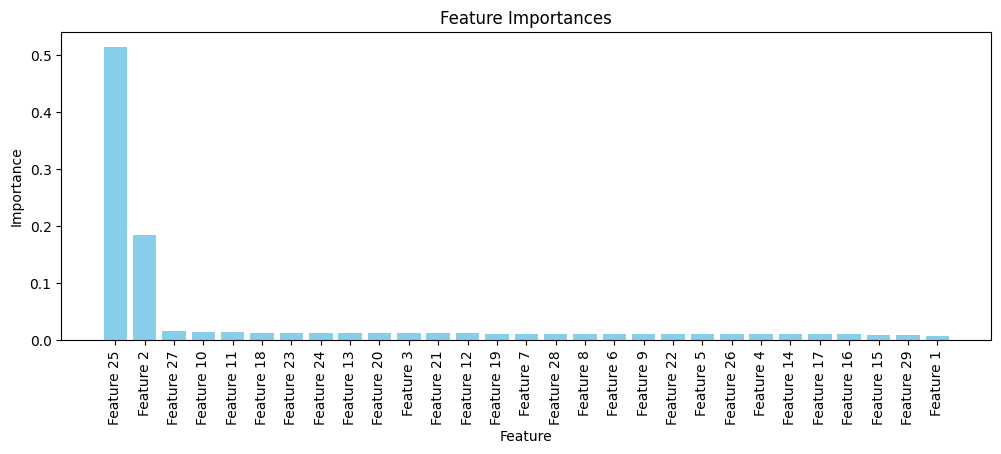

In [31]:
'''compare w/ baseline'''
import matplotlib.pyplot as plt

# 假设 best_model 是已经训练好的模型
# 获取特征重要性
feature_importances = best_model.feature_importances_

# 假设我们知道特征的名字，如果不知道可以用数字代替
feature_names = [f'Feature {i+1}' for i in range(len(feature_importances))]

# 创建一个特征重要性的DataFrame
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# 对特征重要性进行排序
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# 绘制特征重要性的柱状图
plt.figure(figsize=(12, 4))
plt.bar(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)  # 可能需要旋转特征名以便更好地显示
plt.show()


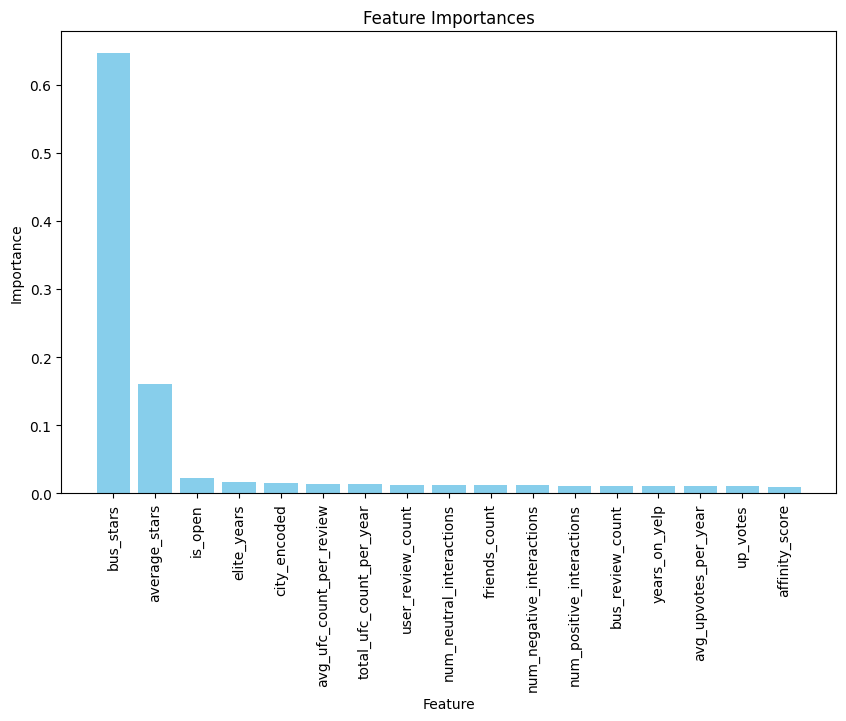

In [65]:
'''baseline'''
import matplotlib.pyplot as plt

# 假设 best_model 是已经训练好的模型
# 获取特征重要性
feature_importances = best_model.feature_importances_

# 假设我们知道特征的名字，如果不知道可以用数字代替
feature_names = ['years_on_yelp', 'average_stars', 'user_review_count', 'up_votes', 'avg_upvotes_per_year', 'friends_count', 'elite_years', 'num_positive_interactions', 'num_negative_interactions', 'num_neutral_interactions', 'total_ufc_count_per_year', 'avg_ufc_count_per_review', 'bus_stars', 'bus_review_count', 'is_open', 'city_encoded', 'affinity_score'] 

# 创建一个特征重要性的DataFrame
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# 对特征重要性进行排序
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# 绘制特征重要性的柱状图
plt.figure(figsize=(10, 6))
plt.bar(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)  # 可能需要旋转特征名以便更好地显示
plt.show()


In [27]:
# 最佳参数: {'learning_rate': 0.05, 'max_depth': 7, 'max_leaves': 120, 'n_estimators': 300}
# 最终测试集上的RMSE: 0.96323351981516

params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.6,
    'gamma': 0.35,
    'learning_rate': 0.03,
    'max_depth': 8,
    'n_estimators': 468,
    'subsample': 0.9
}

最终测试集上的RMSE: 0.9502900488295253

../yelp_true.csv的RMSE: 0.9492449122284947 w/ original user features

In [15]:
y_pred_series = pd.Series(y_pred)
y_pred_clipped = y_pred_series.clip(1, 5)

## Understand your y_pred

In [17]:
# round prediction

# 限制预测评分在1到5之间
y_pred_clipped = y_pred_series.clip(1, 5)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred_clipped))
print("RMSE with predictions clipped between 1 and 5:", rmse)

# 对调整后的预测结果进行四舍五入
y_pred_rounded = y_pred_clipped.round().astype(int)

print("-------------STATS afteer rounded-----------------")
# 进行四舍五入后的基本统计
print(y_pred_rounded.describe())

rmse = np.sqrt(mean_squared_error(y_val, y_pred_rounded))
print("RMSE with predictions rounded (int) between 1 and 5:", rmse)

RMSE with predictions clipped between 1 and 5: 0.9459485319381798
-------------STATS afteer rounded-----------------
count    146996.00
mean          3.74
std           0.61
min           1.00
25%           3.00
50%           4.00
75%           4.00
max           5.00
dtype: float64
RMSE with predictions rounded (int) between 1 and 5: 0.9891930127144891


count    146996.00
mean          3.74
std           0.61
min           1.00
25%           3.00
50%           4.00
75%           4.00
max           5.00
dtype: float64
count    146996.00
mean          3.75
std           1.12
min           1.00
25%           3.00
50%           4.00
75%           5.00
max           5.00
Name: stars, dtype: float64


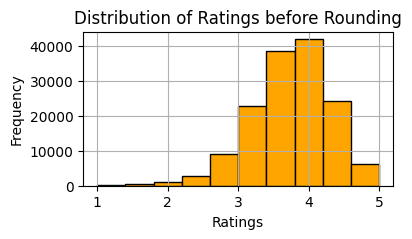

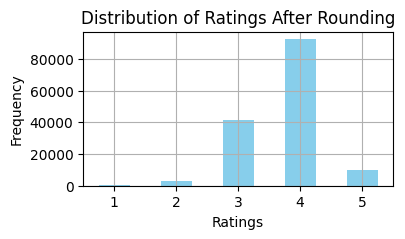

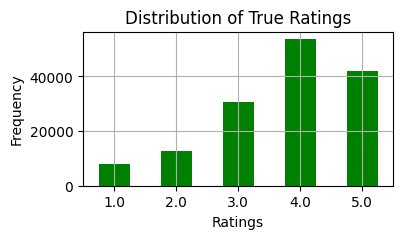

In [18]:
# 输出四舍五入后的评分统计数据
print(y_pred_rounded.describe())
print(y_val.describe())
# 绘制分布图
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 2))
plt.hist(y_pred_clipped, bins=10, color='orange', edgecolor='black')  # 调整bins的数量以获得适当的分布
plt.title('Distribution of Ratings before Rounding')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(4, 2))
y_pred_rounded.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings After Rounding')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

plt.figure(figsize=(4, 2))
y_val.value_counts().sort_index().plot(kind='bar', color='green')
plt.title('Distribution of True Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

# 为实际1-5星评价绘制分布图,根据实际星级分组的误差

In [19]:
y_pred_clipped.name = 'prediction'
y_val.name = 'stars'

df_merged = pd.concat([y_pred_clipped, y_val], axis=1)
df_merged['error'] = df_merged['prediction'] - df_merged['stars']
error_distribution = df_merged.groupby('stars')['error'].describe()

# 根据实际星级分组的误差
print(error_distribution)

         count  mean   std   min   25%   50%   75%   max
stars                                                   
1.0     7818.0  2.04  0.70  0.00  1.61  2.11  2.54  3.69
2.0    12812.0  1.32  0.52 -0.77  0.99  1.35  1.70  2.86
3.0    30492.0  0.53  0.45 -1.65  0.23  0.54  0.85  1.95
4.0    53711.0 -0.21  0.42 -2.44 -0.49 -0.19  0.09  1.00
5.0    42163.0 -0.89  0.45 -3.74 -1.16 -0.85 -0.58  0.00


1-star prediction, 
error distribution: predicted_category
1-Star     179
2-Star    1460
3-Star    4064
4-Star    2084
5-Star      31
Name: count, dtype: int64


/tmp/ipykernel_48701/3805797694.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_star['predicted_category'] = pd.cut(df_star['prediction'], bins=bins, labels=labels, right=False)


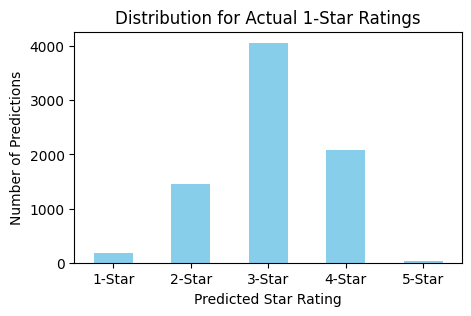

2-star prediction, 
error distribution: predicted_category
1-Star      10
2-Star     821
3-Star    7023
4-Star    4905
5-Star      53
Name: count, dtype: int64


/tmp/ipykernel_48701/3805797694.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_star['predicted_category'] = pd.cut(df_star['prediction'], bins=bins, labels=labels, right=False)


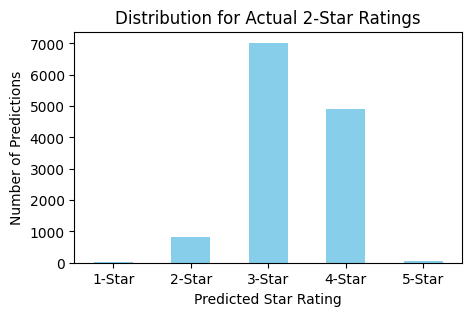

/tmp/ipykernel_48701/3805797694.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_star['predicted_category'] = pd.cut(df_star['prediction'], bins=bins, labels=labels, right=False)


3-star prediction, 
error distribution: predicted_category
1-Star        3
2-Star      477
3-Star    13627
4-Star    16148
5-Star      237
Name: count, dtype: int64


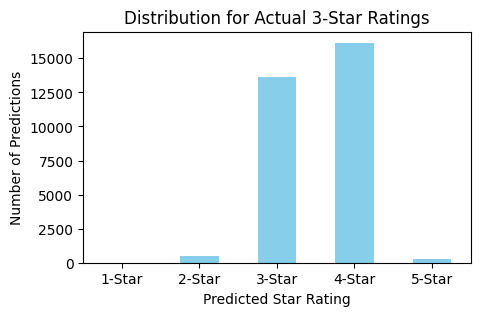

4-star prediction, 
error distribution: predicted_category
1-Star        0
2-Star      242
3-Star    12718
4-Star    39033
5-Star     1718
Name: count, dtype: int64


/tmp/ipykernel_48701/3805797694.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_star['predicted_category'] = pd.cut(df_star['prediction'], bins=bins, labels=labels, right=False)


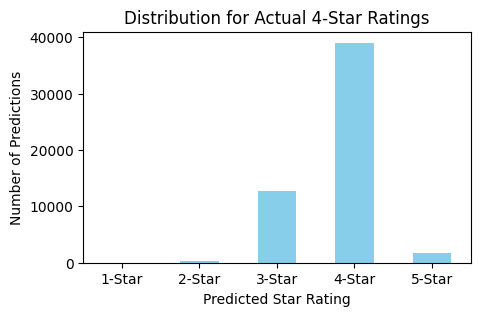

/tmp/ipykernel_48701/3805797694.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_star['predicted_category'] = pd.cut(df_star['prediction'], bins=bins, labels=labels, right=False)


5-star prediction, 
error distribution: predicted_category
1-Star        1
2-Star      110
3-Star     3868
4-Star    30271
5-Star     7913
Name: count, dtype: int64


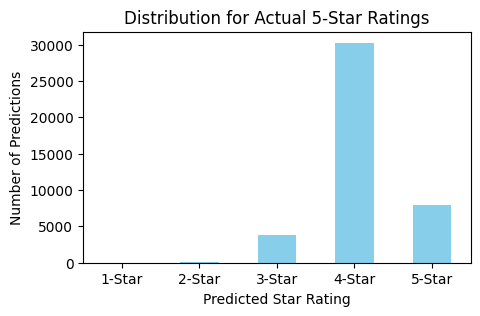

In [20]:
'''统计实际评分（1到5星）被预测为其他评分的情况'''
def plot_distribution(df, actual_star, title):
    df_star = df[df['stars'] == actual_star]

    # 对预测结果进行分档，使用自定义的分割点
    bins = [0, 1.5, 2.5, 3.5, 4.5, 5.5]
    labels = ['1-Star', '2-Star', '3-Star', '4-Star', '5-Star']
    df_star['predicted_category'] = pd.cut(df_star['prediction'], bins=bins, labels=labels, right=False)

    # 计算每个预测类别的数量
    distribution = df_star['predicted_category'].value_counts().reindex(labels, fill_value=0)
    print(f"{actual_star}-star prediction, \nerror distribution: {distribution}")

    # 绘制柱状图
    plt.figure(figsize=(5, 3))
    distribution.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Predicted Star Rating')
    plt.ylabel('Number of Predictions')
    plt.xticks(rotation=0)
    plt.show()

# 调用函数绘制每个实际评分的预测分布图
for star in range(1, 6):
    plot_distribution(df_merged, star, f"Distribution for Actual {star}-Star Ratings")

# (abandoned) FURTHER Fine-Tune ON YELP_TRUE

In [ ]:
# X_val, y_val, X_train, y_train

In [18]:
# !pip install scikit-optimize

     |████████████████████████████████| 107 kB 4.2 MB/s eta 0:00:01


In [19]:
'''!!few CPU consuming and fast!!'''
from skopt import BayesSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from skopt.space import Real, Categorical, Integer
import numpy as np

# # 定义搜索空间
# search_spaces = {
#     'max_depth': Integer(7, 9),  # 在最佳值8附近细化搜索
#     'learning_rate': Real(0.028, 0.032, 'uniform'),  # 继续细化学习率的搜索范围
#     'n_estimators': Integer(460, 480),  # 继续细化估计器数量的范围
#     'subsample': Real(0.88, 0.92),  # 继续细化subsample的范围
#     'colsample_bytree': Real(0.58, 0.62),  # 继续细化colsample_bytree的搜索范围
#     'gamma': Real(0.33, 0.37)  # 继续细化gamma的搜索范围
# }

# 针对性调整搜索空间
search_spaces = {
    'max_depth': Integer(4, 7),
    'learning_rate': Real(0.029, 0.035, 'uniform'),
    'n_estimators': Integer(270, 370),
    'subsample': Real(0.87, 0.93),
    'colsample_bytree': Real(0.58, 0.61),
    'gamma': Real(0.34, 0.40),
    'max_leaves': Integer(20, 126)
}

# 创建XGBRegressor模型实例
model = XGBRegressor(objective='reg:squarederror')

# 创建BayesSearchCV实例
bayes_search = BayesSearchCV(model, search_spaces, n_iter=200, scoring='neg_mean_squared_error', cv=2, n_jobs=-1, return_train_score=False, random_state=42)

# 使用完整的训练集来寻找最佳模型参数
bayes_search.fit(X_train, y_train)

# 输出最佳参数和RMSE
best_model = bayes_search.best_estimator_
y_pred = best_model.predict(X_val)
final_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("最佳参数:", bayes_search.best_params_)
print("最终测试集上的RMSE:", final_rmse)

NameError: name 'X_val' is not defined

In [32]:
y_pred = best_model.predict(X_val)
final_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("最佳参数:", bayes_search.best_params_)
print("最终测试集上的RMSE:", final_rmse)
best_model

最佳参数: OrderedDict([('colsample_bytree', 0.5850269704040795), ('gamma', 0.4), ('learning_rate', 0.035), ('max_depth', 7), ('max_leaves', 55), ('n_estimators', 370), ('subsample', 0.87)])
最终测试集上的RMSE: 0.9783422087564203


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6000253271077364, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.3476073435753331,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03186356519406673,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=480, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

> 最佳参数: OrderedDict([('colsample_bytree', 0.666361195324929), ('gamma', 0.27330837738957436), ('learning_rate', 0.024954301649481384), ('max_depth', 8), ('max_leaves', 100), ('n_estimators', 452), ('subsample', 1.0)])
最终测试集上的RMSE: 0.9678635570041916

> 最佳参数: OrderedDict([('colsample_bytree', 0.6003630307254743), ('gamma', 0.32267450294956274), ('learning_rate', 0.028110340116999862), ('max_depth', 7), ('n_estimators', 458), ('subsample', 0.9274714848835418)])
最终测试集上的RMSE: 0.9640748401060636

> **最佳参数: OrderedDict([('colsample_bytree', 0.6), ('gamma', 0.35), ('learning_rate', 0.029999999999999995), ('max_depth', 8), ('n_estimators', 468), ('subsample', 0.9)])
最终测试集上的RMSE: 0.9500705514804804**

> 最佳参数: OrderedDict([('colsample_bytree', 0.6072881476244077), ('gamma', 0.3628798465362447), ('learning_rate', 0.029227134470457283), ('max_depth', 8), ('n_estimators', 480), ('subsample', 0.8869519293950694)])
最终测试集上的RMSE: 0.9501365283689958

> **最佳参数: OrderedDict([('colsample_bytree', 0.6000253271077364), ('gamma', 0.3476073435753331), ('learning_rate', 0.03186356519406673), ('max_depth', 8), ('n_estimators', 480), ('subsample', 0.8831766281686719)])
最终测试集上的RMSE: 0.9472496841333367**

In [ ]:
# 'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.04, 'max_depth': 7, 'max_leaves': 90, 'n_estimators': 550, 'subsample': 0.9}

In [ ]:
baseline:
最佳参数: {'learning_rate': 0.05, 'max_depth': 7, 'max_leaves': 120, 'n_estimators': 300}
最终测试集上的RMSE: 0.96323351981516
-------------------------------------
最佳参数: {'colsample_bytree': 0.75, 'gamma': 0.3, 'learning_rate': 0.04, 'max_depth': 6, 'n_estimators': 550, 'subsample': 0.95}
最终测试集上的RMSE: 0.966256275391655



## ARCHIVE

In [12]:
# final_data

[{'user_id': 'ObQl16Vuc4sHPGKtzSGNUw',
  'business_id': 'gm8BAH6eZrDkJv0CCas0Bg',
  'stars': 4.0,
  'years_on_yelp': 6.328767123287672,
  'average_stars': 3.84,
  'user_review_count': 417,
  'up_votes': 25,
  'avg_upvotes_per_year': 3.95021645021645,
  'friends_count': 158,
  'elite_years': 3,
  'num_positive_interactions': 9,
  'num_negative_interactions': 29,
  'num_neutral_interactions': 17,
  'total_ufc_count_per_year': 200.2216497795984,
  'avg_ufc_count_per_review': 2.1166666666666667,
  'bus_stars': 4.5,
  'bus_review_count': 88,
  'categories': ['bars',
   'cocktail bars',
   'nightlife',
   'restaurants',
   'lounges',
   'fondue'],
  'city': 'Las Vegas',
  'is_open': 0,
  'city_encoded': 416,
  'review_id': 'AaN59OxHP-Q5-TA8kGKd3w',
  'pos_count': 2,
  'neg_count': 6,
  'ufc_count': 8,
  'ufc_count_per_year': 3.2808988764044944,
  'affinity_score': 0.4367931814220288},
 {'user_id': 'ObQl16Vuc4sHPGKtzSGNUw',
  'business_id': 'gm8BAH6eZrDkJv0CCas0Bg',
  'stars': 4.0,
  'years_o

In [14]:
original_count = len(train_df)  # 获取原始DataFrame的行数
final_rdd_count = res_rdd.count()  # 计算处理后的RDD的行数

print(f"Original count: {original_count}, Final RDD count: {final_rdd_count}")

Original count: 146996, Final RDD count: 7909811


In [18]:
# 检查 user_df 中 user_id 的唯一性
print("Unique user_ids in user_df:", feature_processor.user_df['user_id'].nunique(), "Total records in user_df:", len(feature_processor.user_df))
# 检查 business_df 中 business_id 的唯一性
print("Unique business_ids in business_df:", feature_processor.business_df['business_id'].nunique(), "Total records in business_df:", len(feature_processor.business_df))
# 检查 review_df 中 business_id 的唯一性
print("Unique review_df in review_df:", feature_processor.review_df['business_id'].nunique(), "Total records in review_df:", len(feature_processor.review_df))

Unique user_ids in user_df: 1518169 Total records in user_df: 1518169
Unique business_ids in business_df: 188593 Total records in business_df: 188593
Unique review_df in review_df: 24732 Total records in review_df: 455855


In [17]:
from MF import matrix_factorization_als

final_scores_rdd, final_user_features_rdd, final_biz_features_rdd = matrix_factorization_als(
    sc, data_folder_path, file_path
)
user_features_df = pd.DataFrame(list(final_user_features_rdd.collect()))
biz_features_df = pd.DataFrame(list(final_biz_features_rdd.collect()))
final_scores_df = pd.DataFrame(list(final_scores_rdd.collect()))

user_features_df.columns = ['user_id', 'user_features']
biz_features_df.columns = ['business_id', 'biz_features']
final_scores_df.columns = ['user_business', 'affinity_score']

final_scores_df[['user_id', 'business_id']] = pd.DataFrame(final_scores_df['user_business'].tolist(), index=final_scores_df.index)
final_scores_df.drop(columns=['user_business'], inplace=True)

# 合并用户特征和商家特征到一个DataFrame
features_df = pd.concat([user_features_df.set_index('user_id'), biz_features_df.set_index('business_id')], axis=1, keys=['user_features', 'biz_features'])

# 合并亲和力分数
features_df = features_df.reset_index().merge(final_scores_df, on=['user_id', 'business_id'], how='left')

# 现在将这个features_df合并到train_df
train_df = train_df.merge(features_df, on=['user_id', 'business_id'], how='left')

In [ ]:
duplicated_business_ids = biz_features_df[biz_features_df.duplicated('business_id', keep=False)]
duplicated_user_ids = user_features_df[user_features_df.duplicated('user_id', keep=False)]

# 定义一个函数检查向量是否全为0
def is_not_zero_vector(vector):
    return not np.all(np.array(vector) == 0)

# 筛选出向量非空的行
non_empty_business_vectors = duplicated_business_ids[duplicated_business_ids['biz_features'].apply(is_not_zero_vector)]
non_empty_user_vectors = duplicated_user_ids[duplicated_user_ids['user_features'].apply(is_not_zero_vector)]

## SANITY CHECK

In [ ]:
# print("Duplicated but non-empty business_ids in biz_features_df:")
# print(non_empty_business_vectors)
# print("Duplicated but non-empty user_ids in user_features_df:")
# print(non_empty_user_vectors)

In [18]:
# 检查user_id和business_id是否唯一
print("Unique user_ids:", user_features_df['user_id'].is_unique)
print("Unique business_ids:", biz_features_df['business_id'].is_unique)

Unique user_ids: False
Unique business_ids: False


In [23]:
duplicated_user_ids = user_features_df[user_features_df.duplicated('user_id', keep=False)]
print("Duplicated user_ids in user_features_df:")
print(duplicated_user_ids)

Duplicated user_ids in user_features_df:
                      user_id                                      user_features
42     hVidDZUvOiy3xl0v3WKJlg  [-3.2705695629119873, -2.297943353652954, 2.25...
62     2pN7H-6Sa38MGVRoDPAlyQ  [0.656044065952301, -0.48291778564453125, -0.4...
122    9HZSqrJhVZkjJxKVaOICbg  [0.447206974029541, -0.42813563346862793, -1.3...
124    HvZQ9qFkRSxRCI0tMQ6nLA  [0.6126260757446289, -0.11655178666114807, -1....
212    ltszS93IpYxdL6X7TioW1A  [-0.32068267464637756, 0.5590187311172485, 0.6...
...                       ...                                                ...
35860  _ReALUaGu7Qayk4ULX9wnQ  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
35861  FpqMgETBdQZC6DFclkrqLA  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
35862  Dn8PSKgNszrWjyfu6l9NOw  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
35863  Hk7n0zKhcrRwkvqgb_MQ3Q  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
35864  ZMBIjbnvatw6Z6JNPlS99Q  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [24]:
# 检查 biz_features_df 中的非唯一 business_id
duplicated_business_ids = biz_features_df[biz_features_df.duplicated('business_id', keep=False)]
print("Duplicated business_ids in biz_features_df:")
print(duplicated_business_ids)

Duplicated business_ids in biz_features_df:
                  business_id                                       biz_features
0      azE1DNVQFBU8boVbaJhj7w  [-0.069764643907547, 0.07717323303222656, -0.0...
1      cGQKUOAZm_VHcQOJWbatog  [-0.06328084319829941, 0.05636825039982796, -0...
2      7wMB3wMbOp0gq3l6nHfOaA  [-0.04981762170791626, 0.03817032277584076, 0....
4      G2hXfdIKdhI6TVQrXpTnFA  [-0.05244649946689606, 0.009833292104303837, -...
5      k8NHw2fUjisdp38PLCl0JA  [-0.05097943916916847, 0.02158268168568611, -0...
...                       ...                                                ...
48268  uOh6X33yWo03vp2kKqEXmA  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
48269  ZWcXoh_RO7rT2DdcyOzyfQ  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
48270  272a60ze8sADYRR6GyJ3GA  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
48271  HFPovXxiMQ451N80-E-vyQ  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
48272  vchjO0Vs5FwW2tpFnCimqg  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

## Train data TestGround Start Here 

In [ ]:
## GRID SEARCH

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.04, 0.05, 0.06],
    'n_estimators': [450, 500, 550],
    'max_leaves': [90, 100, 110],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score (MSE):", -grid_search.best_score_)

if (-grid_search.best_score_ < min_mse):
    min_mse = -grid_search.best_score_
else:
    print("no better\n")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
rmse = sqrt(mean_squared_error(y_val, y_pred))
print("RMSE on true set:", rmse)

results.append({
    'param_grid': param_grid,
    'best_params': grid_search.best_params_,
    'best_score': np.sqrt(-grid_search.best_score_),
    'rmse': rmse
})